<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/main/Efficient_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion models Testing

In this document we test and build diffusion models and its variations

# Solving the KFP equation

We present classical methods to solve the KFP forward equation

## Libraries

In [44]:
## We start with standard diffusion model denoising diffusion probability model
## we first start by loading the required packages
import torch
import functools
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy.sparse import coo_array
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Loading MNIST Digits

In [45]:
# download mnist dataset
mnist = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# mnist_data = np.moveaxis(mnist.data.numpy(), 0, -1)
# mnist_data.shape
mnist_data = mnist.data.numpy()
print(mnist_data.shape)

(60000, 28, 28)


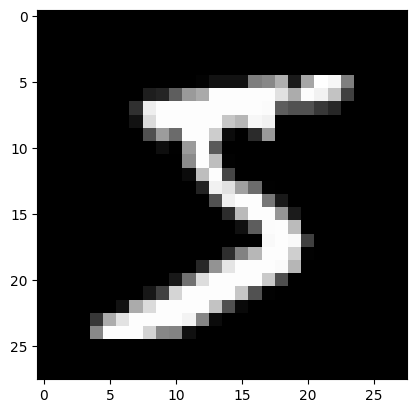

In [46]:
# look at one of the images

plt.imshow(mnist_data[0,:,:], cmap="gray")

## Solving the KFP Equation

In [47]:
## we construct coefficient matrix and constant matrix
def construct_A(dx,dy,dt,f,g,s,H,W):
  A = np.eye(H*W)/dt + np.diag((f - 0.5*((g**2)*s)).ravel())/dx + np.diag((f - 0.5*((g**2)*s)).ravel())/dy \
                  + np.diag((-f + 0.5*((g**2)*s)).ravel()[1:],1)/dx + np.diag((-f + 0.5*((g**2)*s)).ravel()[1:],-1)/dy
  return A

def construct_B(dx,dy,dt,m_prev,f,g,s):
  B = m_prev - (np.diff(f, axis=0, prepend=f[0,0]).ravel()*dt/dx + np.diff(f, axis=-1, prepend=f[0,0]).ravel()*dt/dy \
               - 0.5*(g**2)*(np.diff(s, axis=0, prepend = s[0,0]).ravel()*dt/dx + np.diff(s, axis=-1, prepend = s[0,0]).ravel()*dt/dy))
  return B/dt

def solve_pde(A,b):
  return sp.linalg.solve(A, b)

# def repeat_along_diag(a, r):
#   m,n = a.shape
#   out = np.zeros((r,m,r,n), dtype=a.dtype)
#   diag = np.einsum('ijik->ijk',out)
#   diag[:] = a
#   return out.reshape(-1,n*r)

In [48]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t

## Initialize

In [214]:
## construct the grid and Initial values
batch_size = 32
N_img = mnist.data.shape[0] //batch_size # for denoising, just use a constant
N = 10
H = mnist.data.shape[1]
W = mnist.data.shape[2]
epoch = 50
eps = 1e-6

dataset = mnist
dx = mnist.data[0].detach().numpy().max()/H
dy = mnist.data[0].detach().numpy().max()/W
data_loader = DataLoader(dataset, batch_size=N, shuffle=True, num_workers=1)

t = np.linspace(eps, 1, N)
dt = t.max()/N

# f = np.zeros((N, H, W))
# g = np.zeros_like(f)
m = np.zeros((N, H*W), dtype=np.float32)
x = torch.zeros((N, 1, H, W))
del_m = np.zeros_like(m, dtype=np.float32)
perturbed_x = torch.zeros_like(x)
scores = np.zeros((N, H, W), dtype=np.float32)
sigma_ = np.ones(N, dtype=np.float32)

sigma = 2 # in our application sigma needs to be small

## Define the network model

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=True)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=True)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.nn.functional.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # # Normalize output
    # h = h / (2*(diffusion_coeff(t, sigma))**2)[:, None, None, None]
    return h

## Train N timestep

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(9.3039) tensor(-8.9613) 6.4287877 -6.4177437


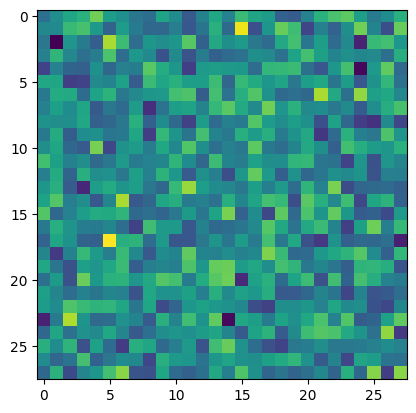

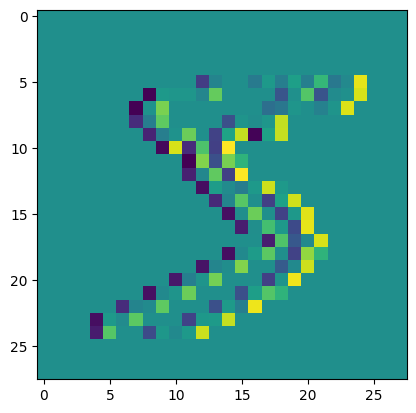

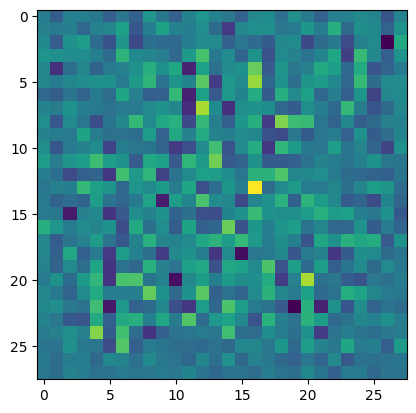

  2%|▏         | 1/50 [00:12<10:17, 12.59s/it]

tensor(8.5347) tensor(-8.3455) 8.807612 -10.090101


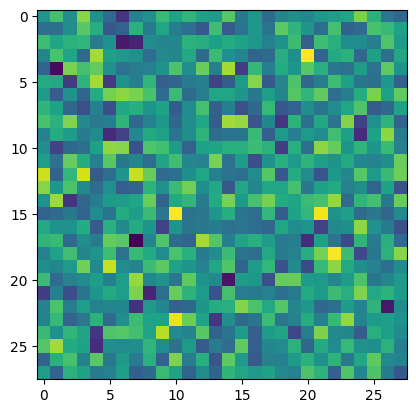

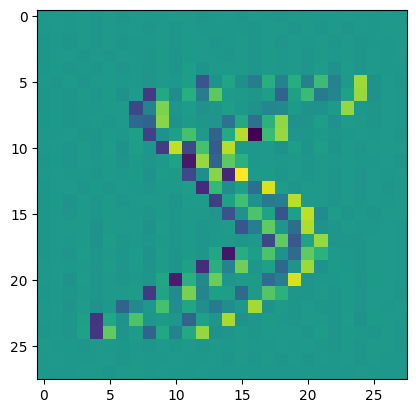

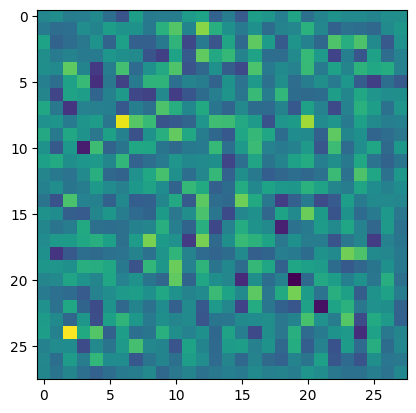

  4%|▍         | 2/50 [00:25<10:10, 12.72s/it]

tensor(9.7771) tensor(-9.4026) 7.1371336 -8.421167


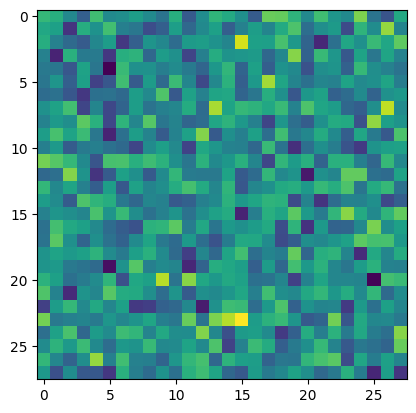

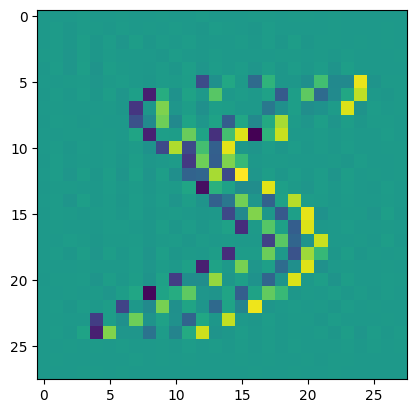

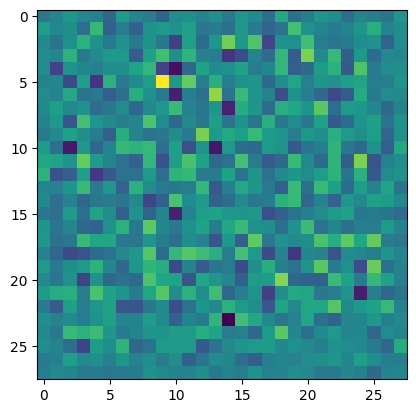

  6%|▌         | 3/50 [00:37<09:53, 12.62s/it]

tensor(10.6869) tensor(-8.6107) 6.9414682 -7.622289


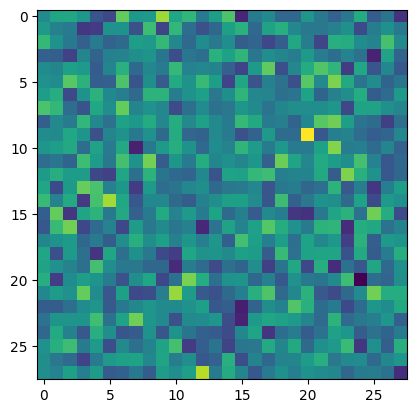

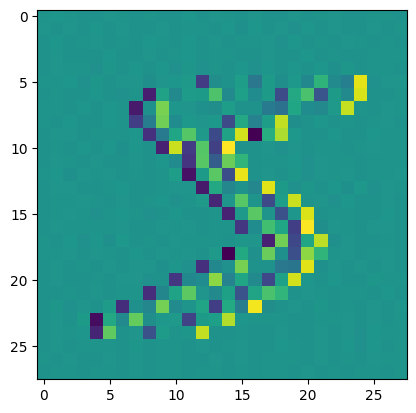

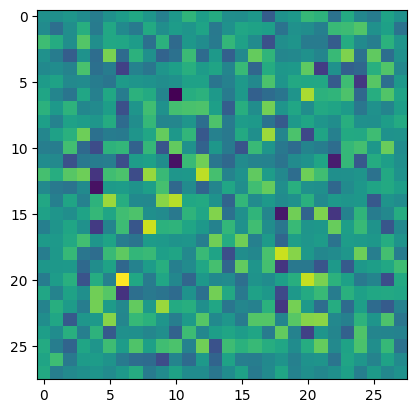

  8%|▊         | 4/50 [00:50<09:43, 12.69s/it]

tensor(9.0827) tensor(-9.1697) 6.971417 -7.4010444


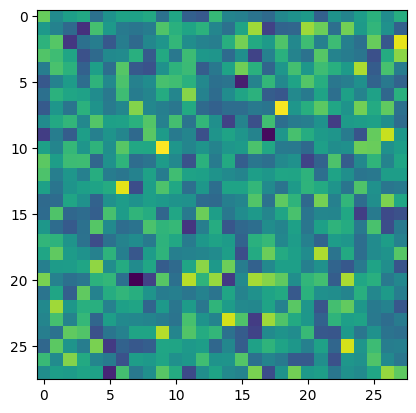

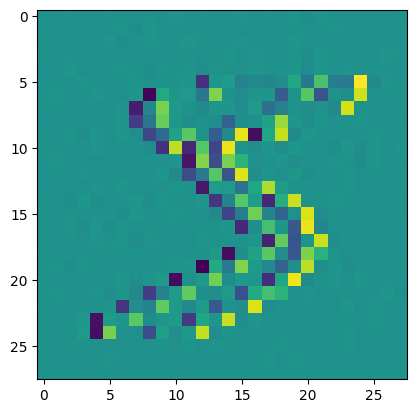

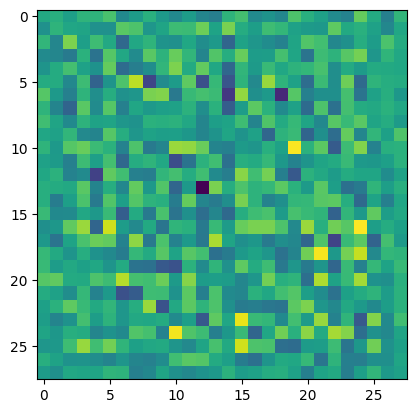

 10%|█         | 5/50 [01:03<09:31, 12.70s/it]

tensor(8.5207) tensor(-8.4287) 6.7804294 -7.5060887


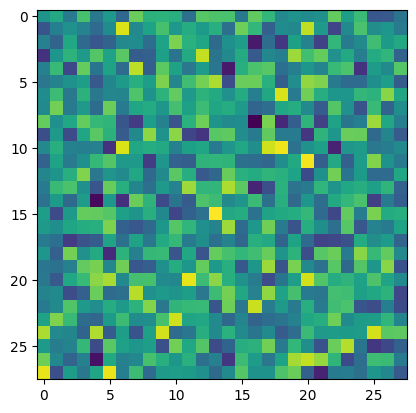

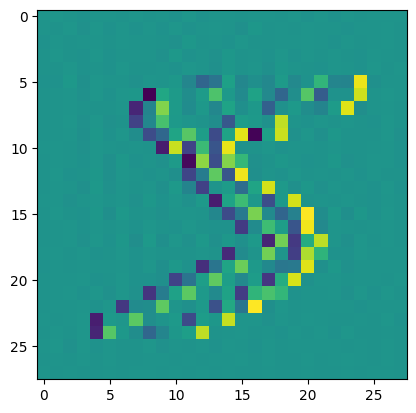

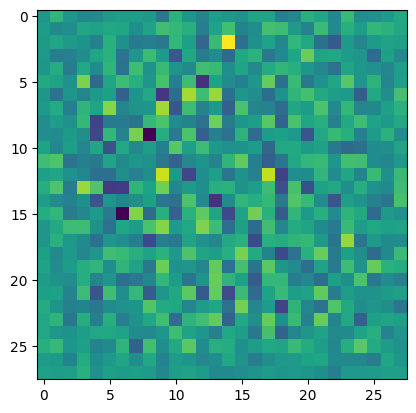

 12%|█▏        | 6/50 [01:16<09:17, 12.66s/it]

tensor(8.5301) tensor(-9.9846) 7.1744375 -8.513083


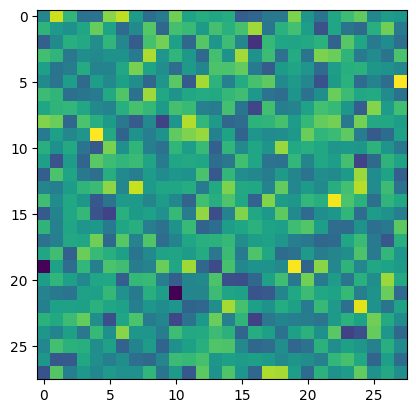

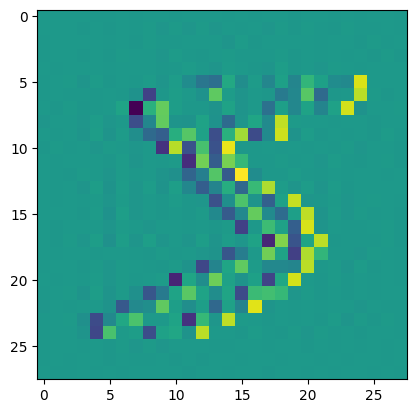

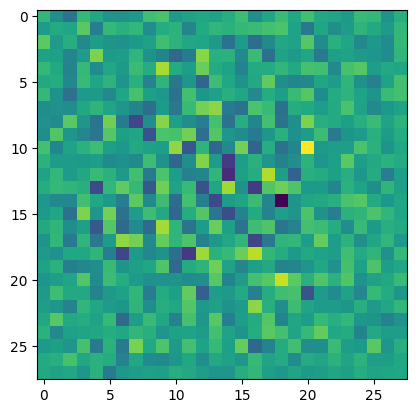

 14%|█▍        | 7/50 [01:28<09:04, 12.66s/it]

tensor(11.4469) tensor(-8.6039) 6.630025 -6.526404


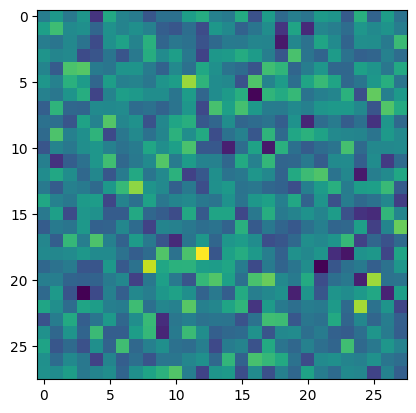

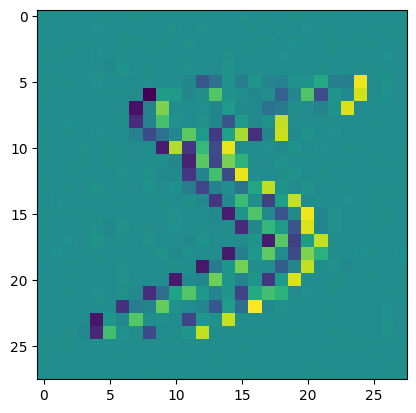

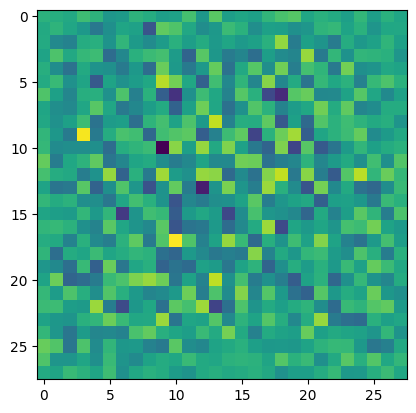

 16%|█▌        | 8/50 [01:41<08:50, 12.62s/it]

tensor(9.5017) tensor(-10.5745) 6.452279 -6.683945


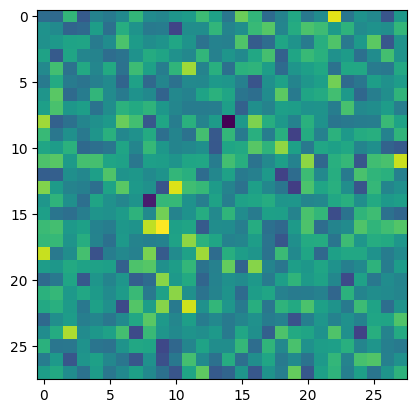

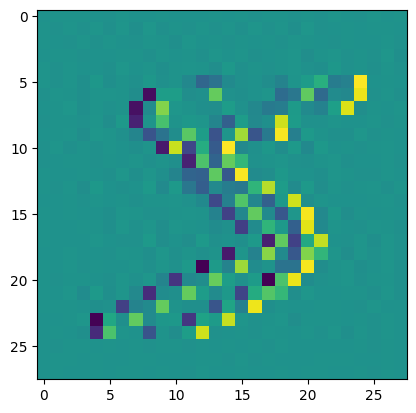

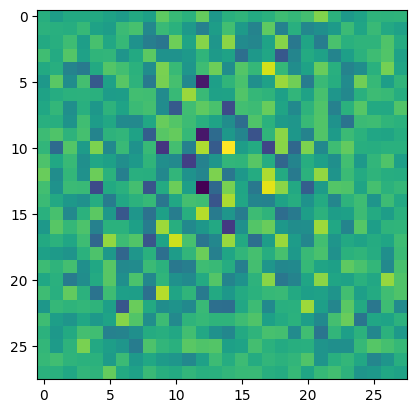

 18%|█▊        | 9/50 [01:53<08:38, 12.65s/it]

tensor(9.3098) tensor(-8.7361) 7.6315594 -8.927457


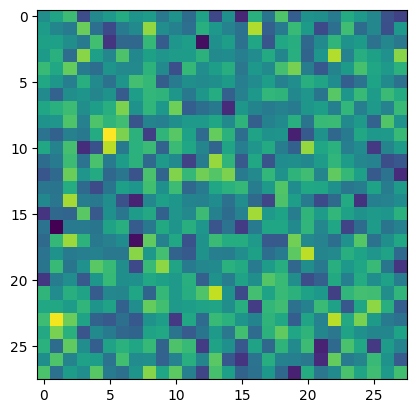

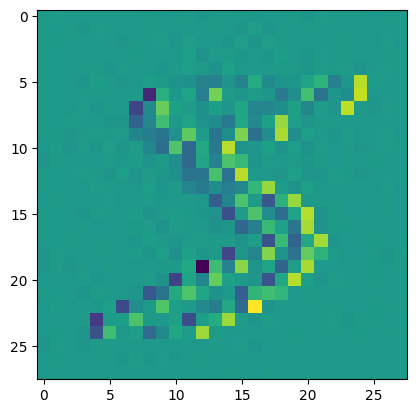

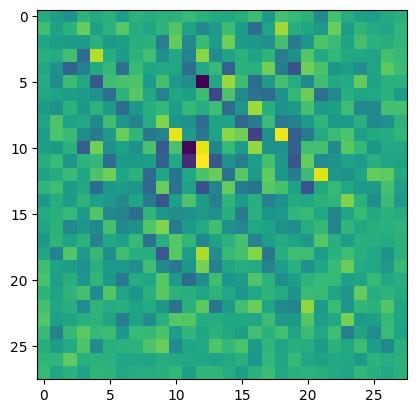

 20%|██        | 10/50 [02:06<08:24, 12.61s/it]

tensor(8.8784) tensor(-9.9196) 6.428876 -7.2513328


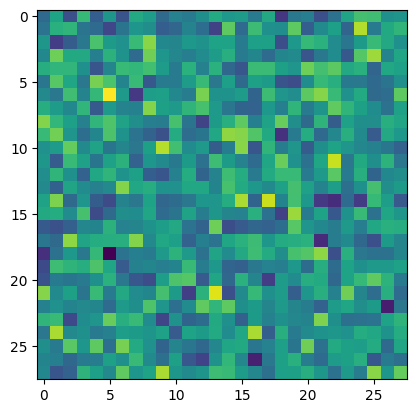

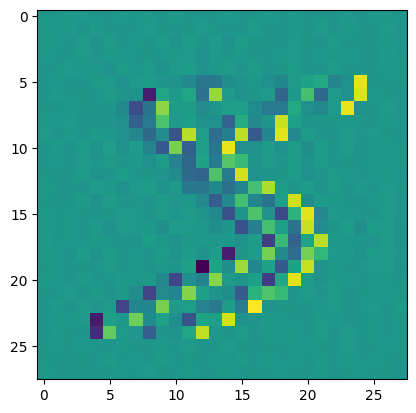

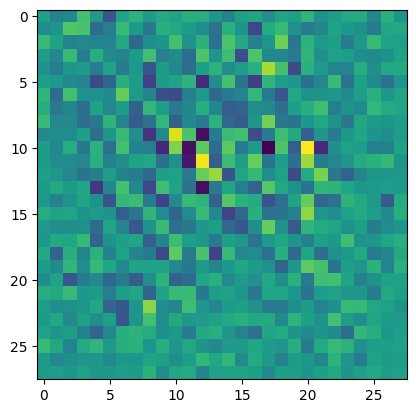

 22%|██▏       | 11/50 [02:18<08:10, 12.58s/it]

tensor(10.3141) tensor(-8.9899) 6.428787 -7.3952646


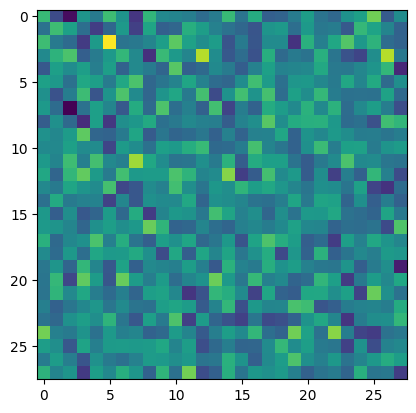

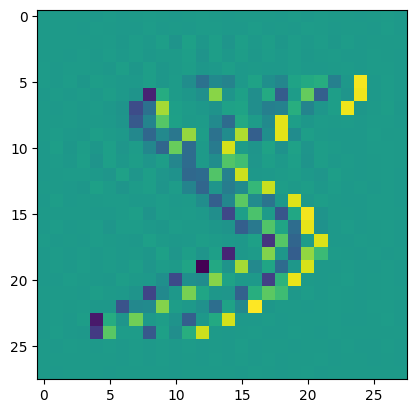

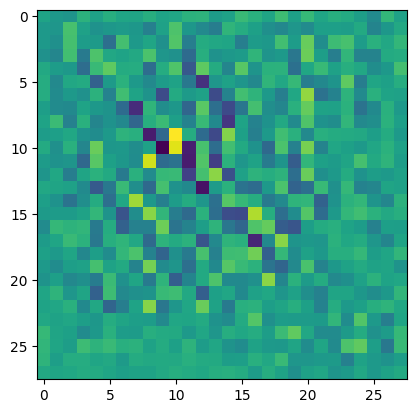

 24%|██▍       | 12/50 [02:31<07:55, 12.52s/it]

tensor(12.1131) tensor(-8.8431) 6.428787 -7.202937


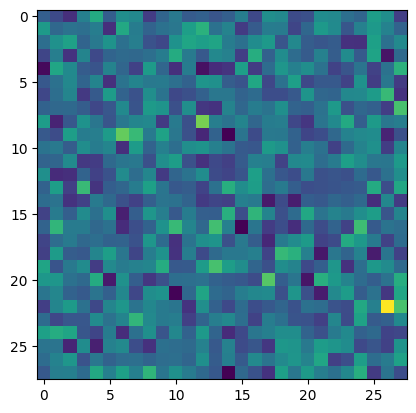

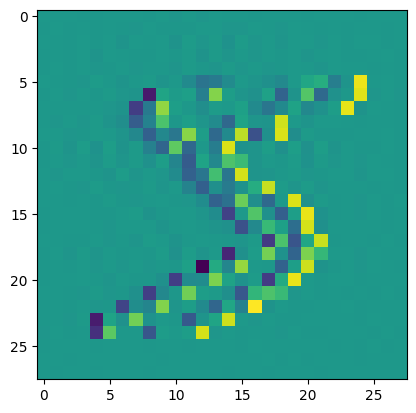

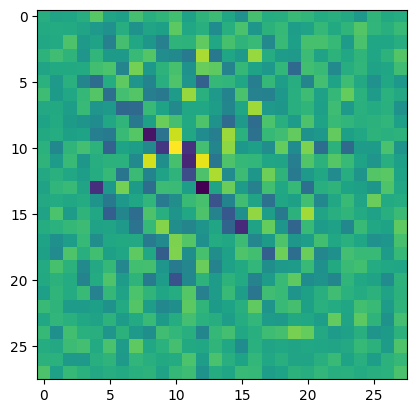

 26%|██▌       | 13/50 [02:43<07:43, 12.53s/it]

tensor(10.4199) tensor(-11.2119) 6.824362 -8.283224


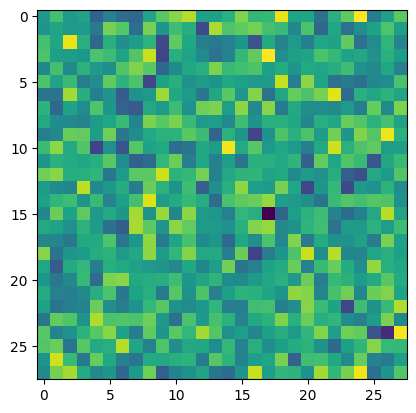

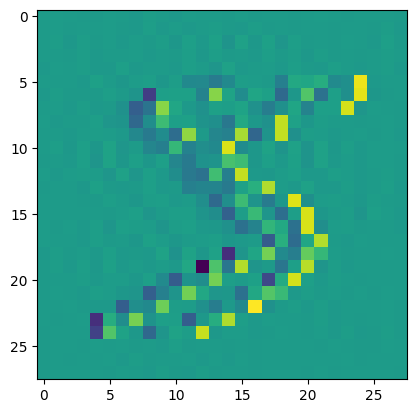

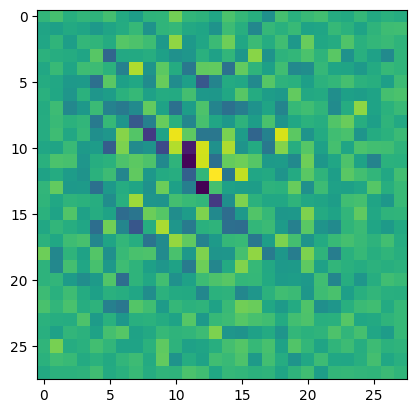

 28%|██▊       | 14/50 [02:56<07:30, 12.52s/it]

tensor(9.5320) tensor(-8.3540) 6.827496 -7.014803


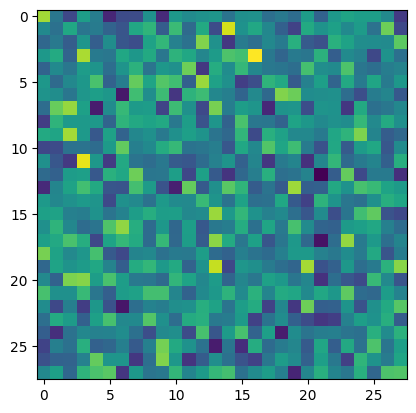

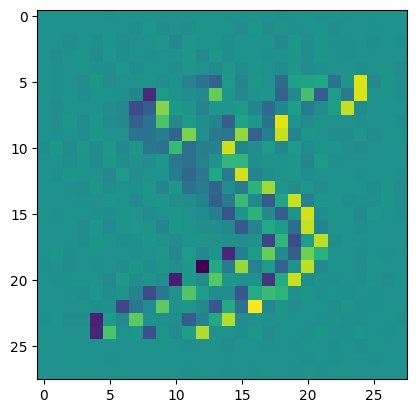

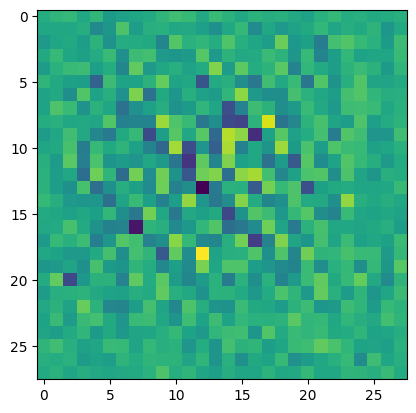

 30%|███       | 15/50 [03:08<07:15, 12.45s/it]

tensor(9.8622) tensor(-9.9891) 6.6132936 -6.5204725


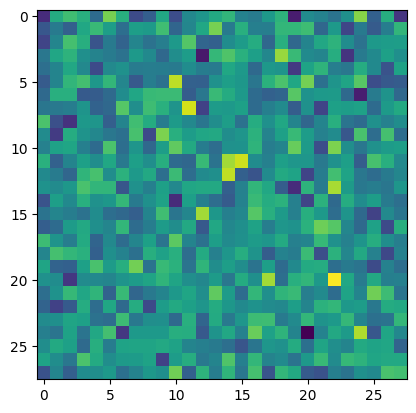

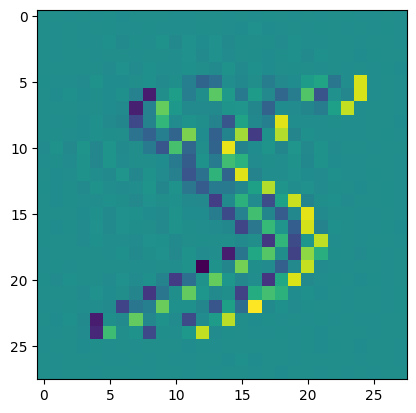

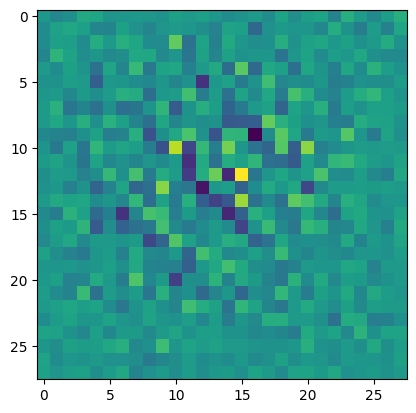

 32%|███▏      | 16/50 [03:20<06:57, 12.28s/it]

tensor(9.8617) tensor(-10.1610) 7.248951 -6.952609


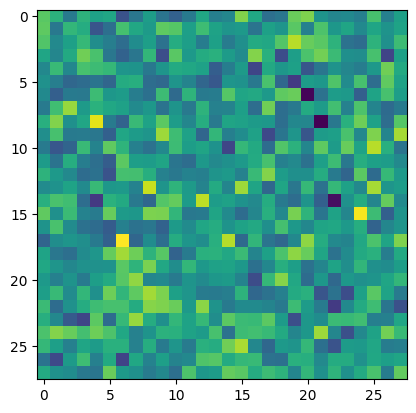

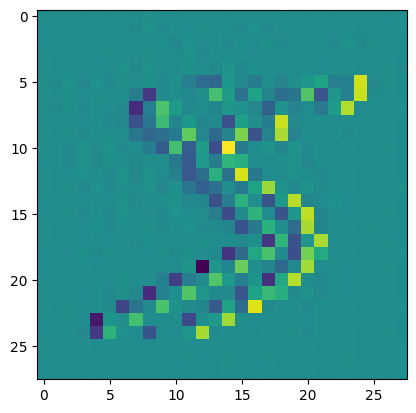

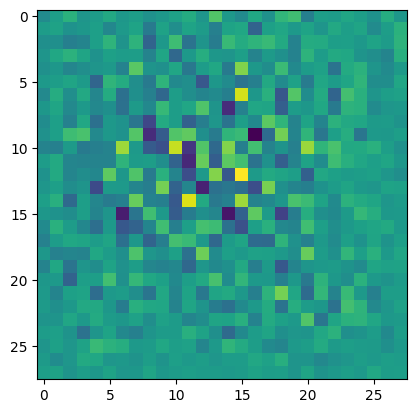

 34%|███▍      | 17/50 [03:32<06:39, 12.12s/it]

tensor(8.8374) tensor(-9.3355) 7.3014617 -6.469369


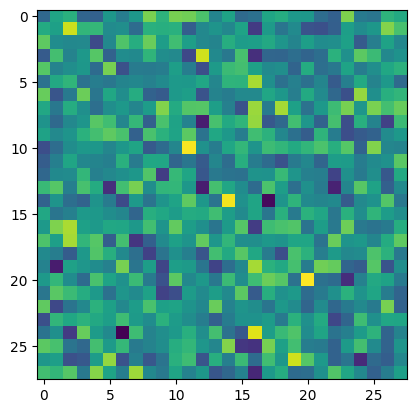

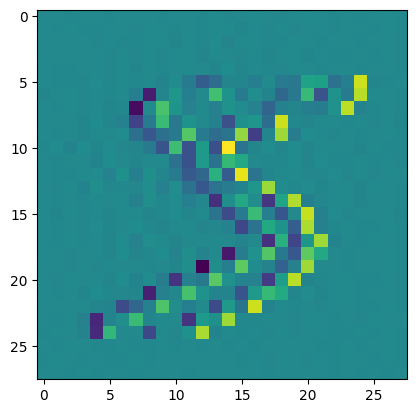

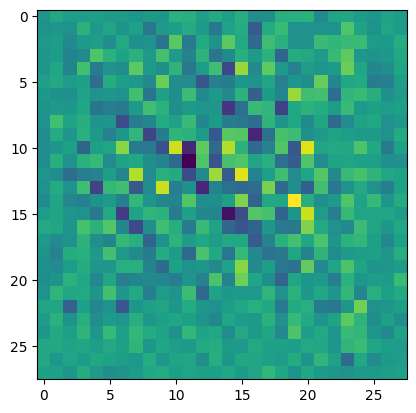

 36%|███▌      | 18/50 [03:44<06:25, 12.04s/it]

tensor(8.9171) tensor(-9.5618) 9.682222 -7.1910872


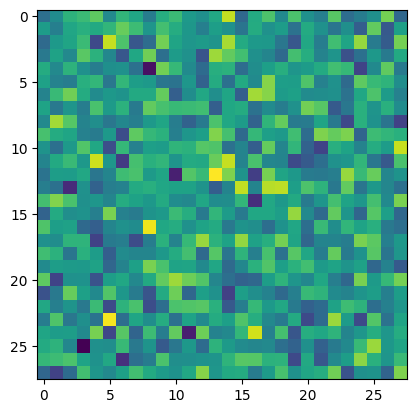

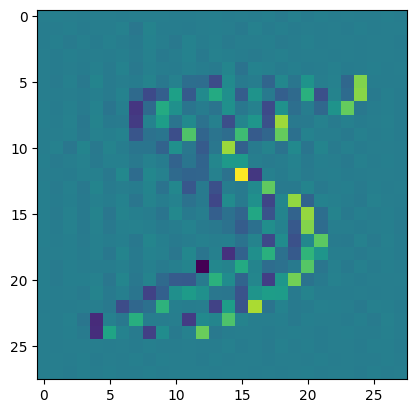

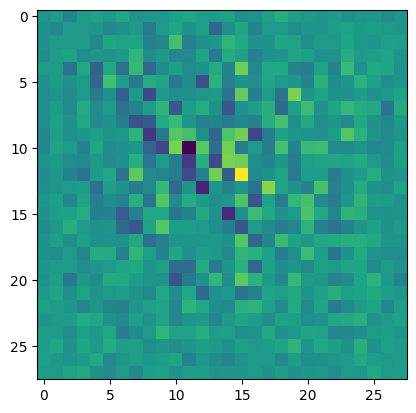

 38%|███▊      | 19/50 [03:55<06:09, 11.92s/it]

tensor(7.9308) tensor(-8.2041) 6.7118244 -6.417743


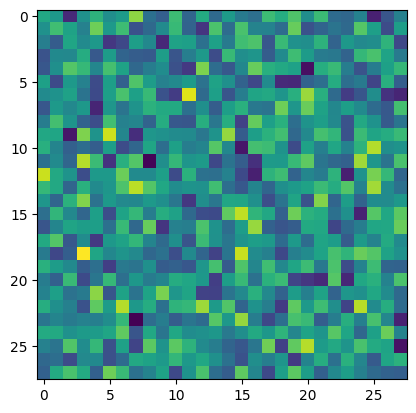

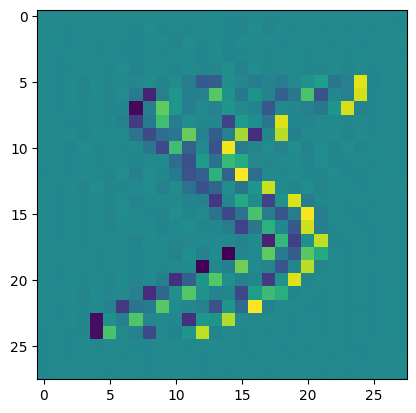

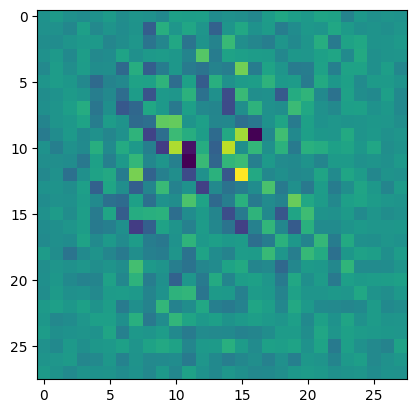

 40%|████      | 20/50 [04:07<05:54, 11.81s/it]

tensor(10.0269) tensor(-10.0934) 6.912017 -6.417743


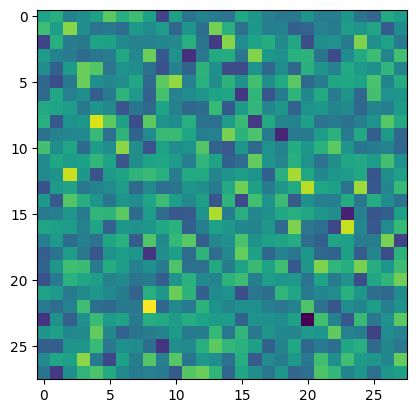

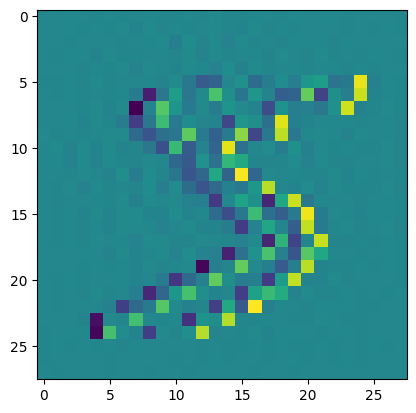

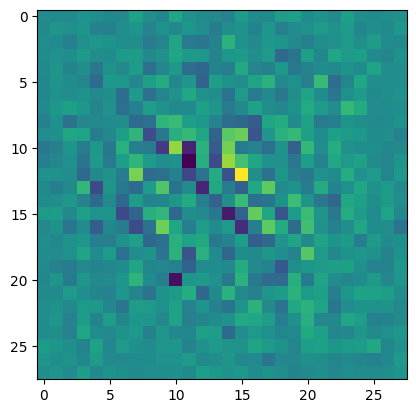

 42%|████▏     | 21/50 [04:19<05:45, 11.92s/it]

tensor(8.8182) tensor(-10.3683) 10.349928 -6.431613


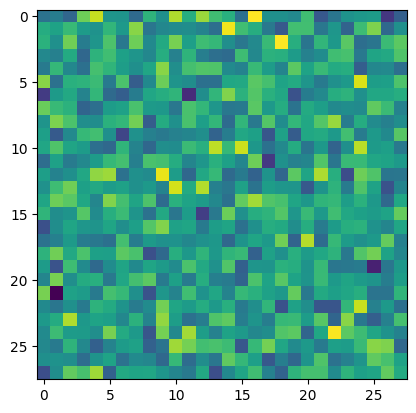

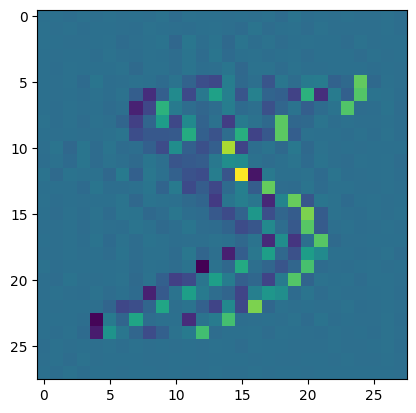

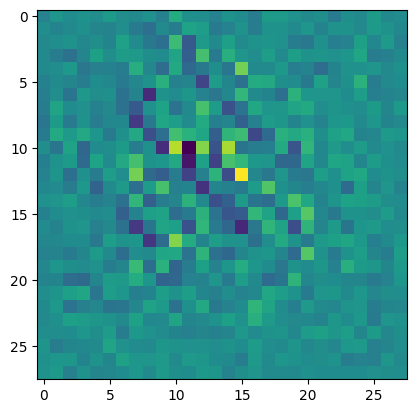

 44%|████▍     | 22/50 [04:32<05:44, 12.31s/it]

tensor(11.6443) tensor(-9.9895) 7.276903 -6.784072


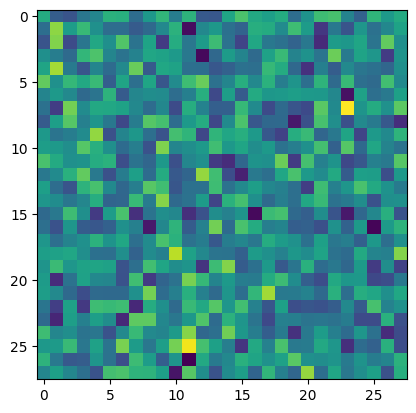

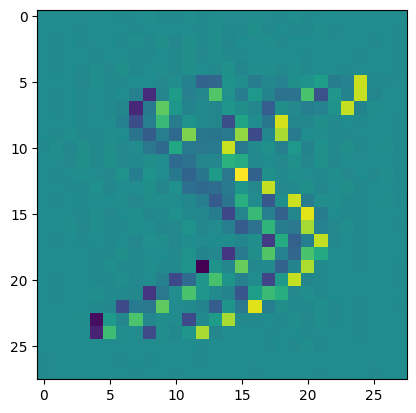

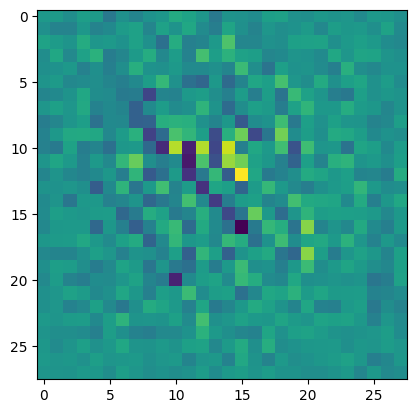

 46%|████▌     | 23/50 [04:45<05:37, 12.49s/it]

tensor(10.7854) tensor(-8.5448) 8.64533 -6.417743


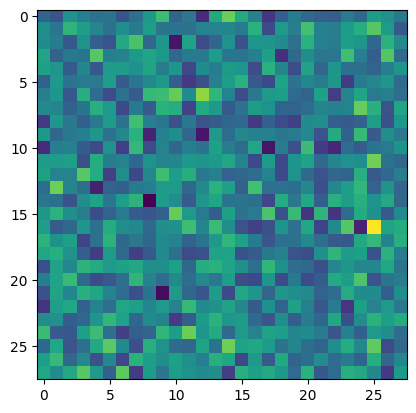

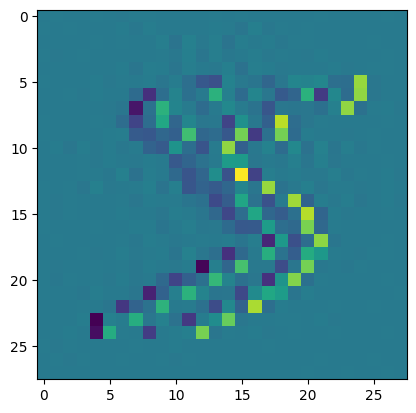

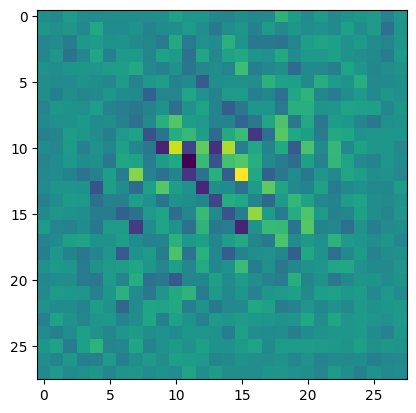

 48%|████▊     | 24/50 [04:58<05:23, 12.45s/it]

tensor(9.1403) tensor(-8.0682) 8.068987 -6.417898


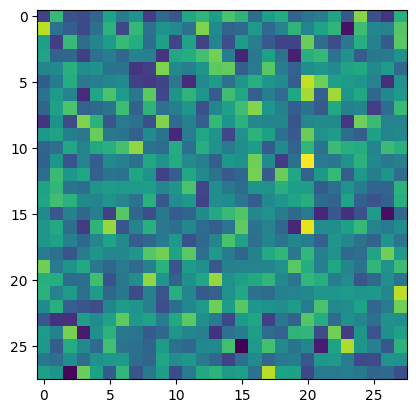

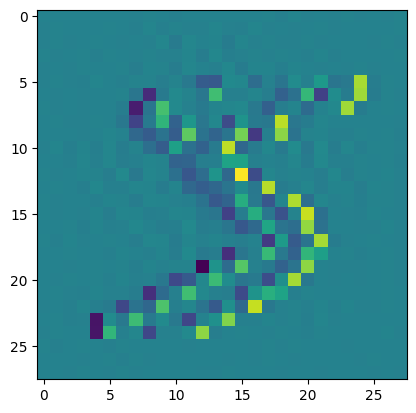

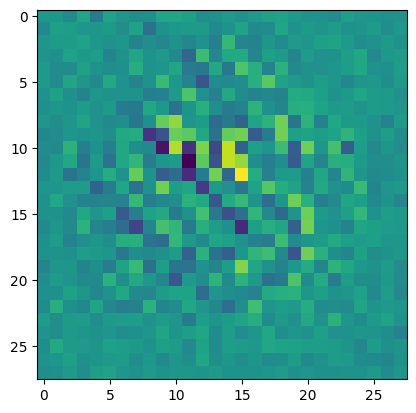

 50%|█████     | 25/50 [05:10<05:15, 12.61s/it]

tensor(9.1365) tensor(-9.1838) 7.6339993 -6.417743


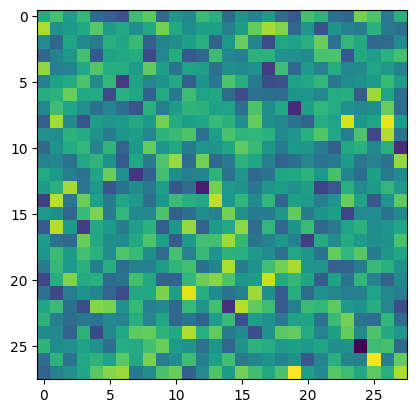

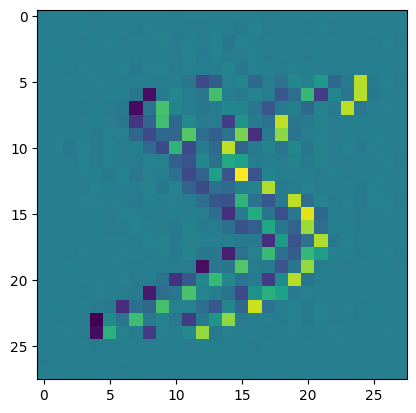

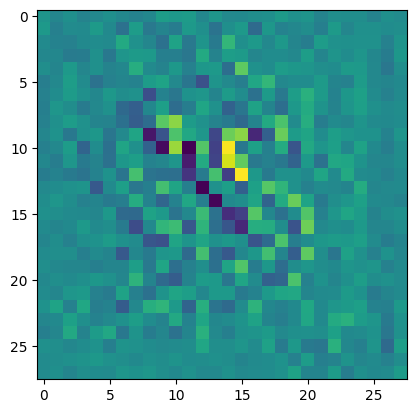

 52%|█████▏    | 26/50 [05:24<05:05, 12.73s/it]

tensor(9.3277) tensor(-8.8630) 8.973585 -6.417743


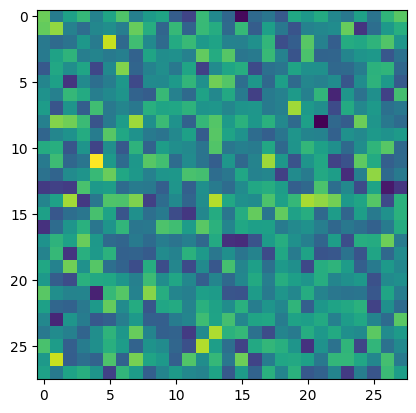

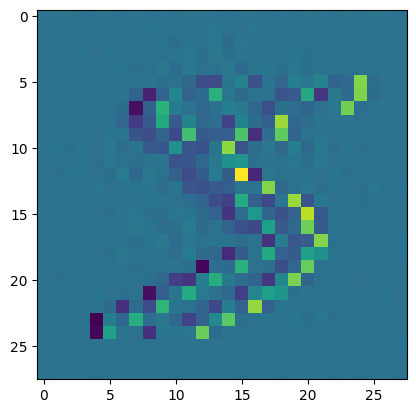

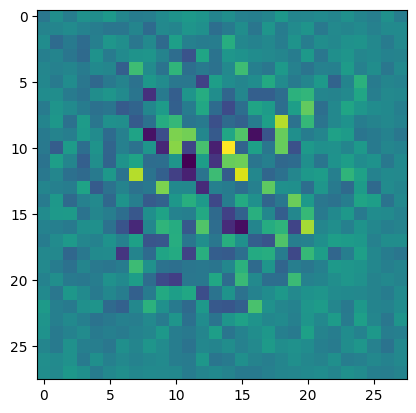

 54%|█████▍    | 27/50 [05:36<04:52, 12.70s/it]

tensor(11.3026) tensor(-8.6103) 7.846595 -6.417743


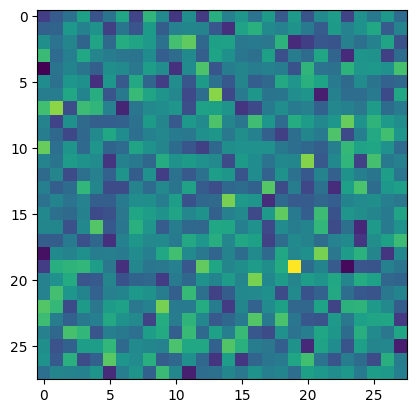

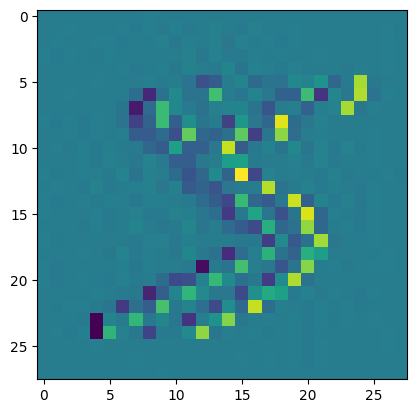

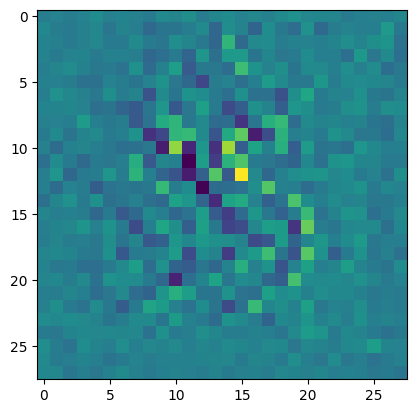

 56%|█████▌    | 28/50 [05:49<04:38, 12.64s/it]

tensor(9.9429) tensor(-8.5195) 9.135464 -6.417743


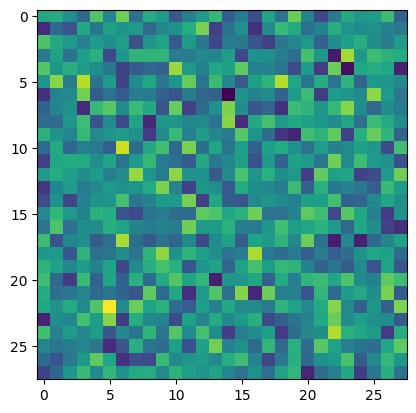

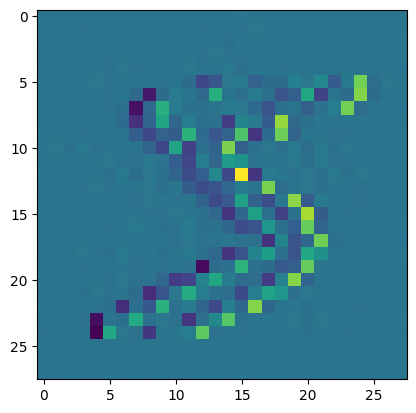

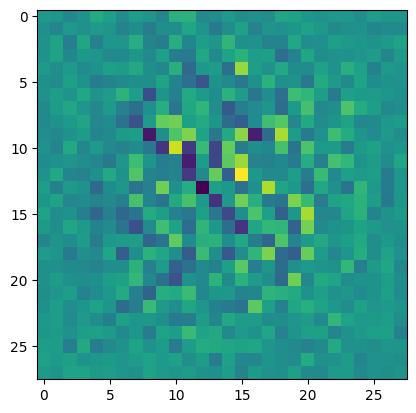

 58%|█████▊    | 29/50 [06:01<04:25, 12.66s/it]

tensor(9.0766) tensor(-8.5955) 7.467768 -6.417743


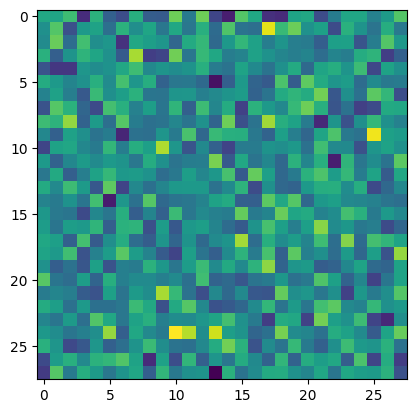

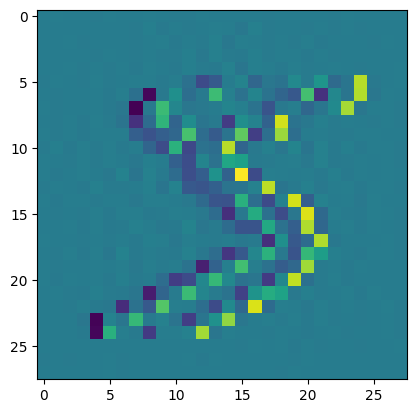

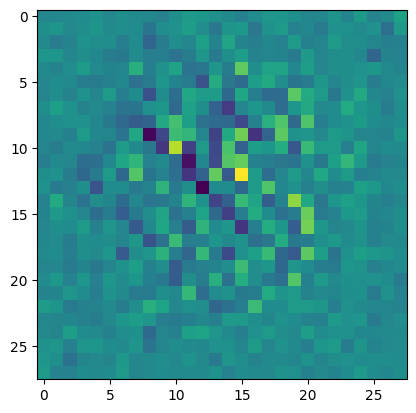

 60%|██████    | 30/50 [06:15<04:17, 12.85s/it]

tensor(9.1085) tensor(-8.4609) 8.347554 -6.417743


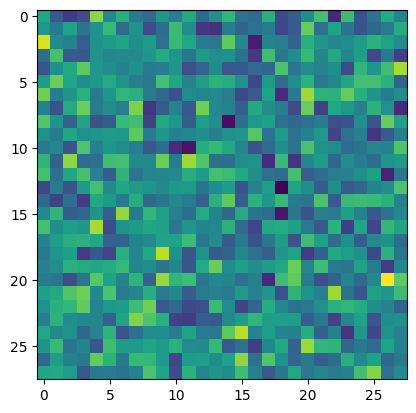

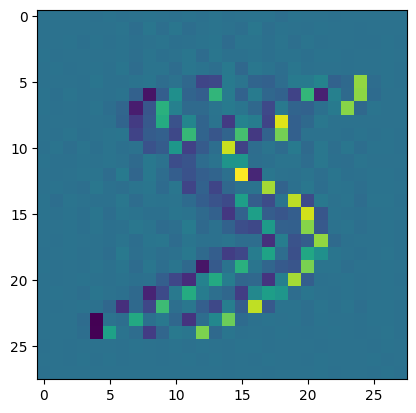

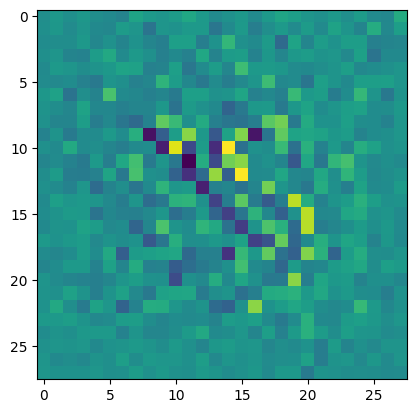

 62%|██████▏   | 31/50 [06:29<04:10, 13.18s/it]

tensor(8.1089) tensor(-9.1115) 7.598283 -6.417743


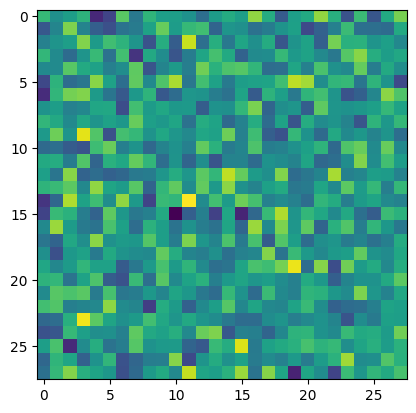

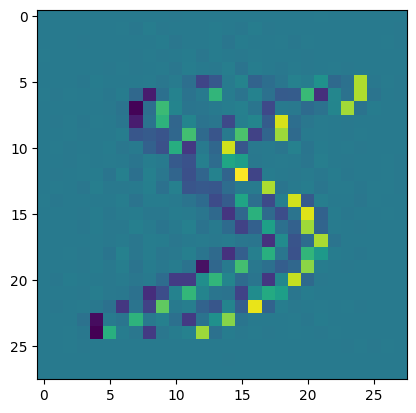

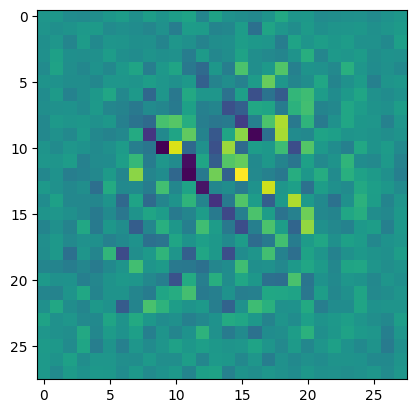

 64%|██████▍   | 32/50 [06:41<03:53, 12.95s/it]

tensor(8.1578) tensor(-8.6394) 7.595684 -6.417743


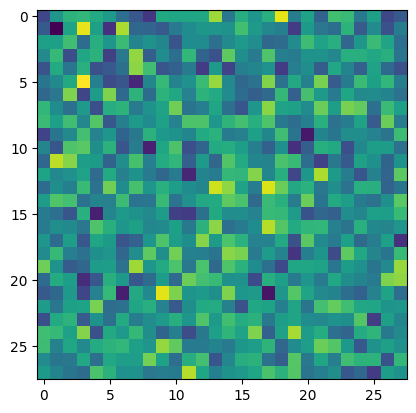

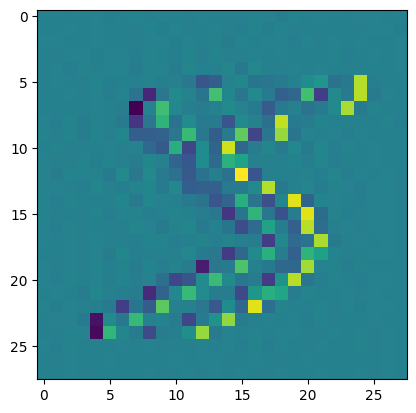

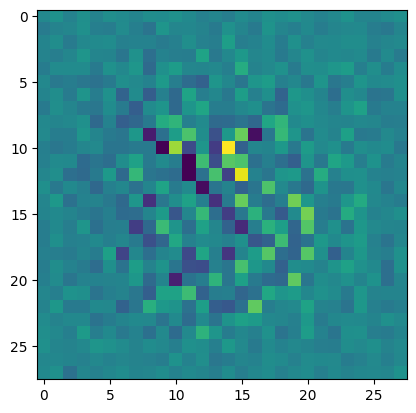

 66%|██████▌   | 33/50 [06:55<03:44, 13.22s/it]

tensor(9.4367) tensor(-8.7385) 14.025478 -7.968702


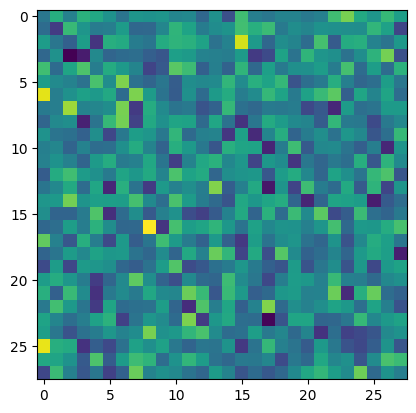

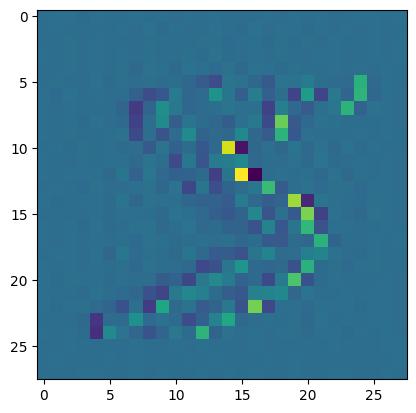

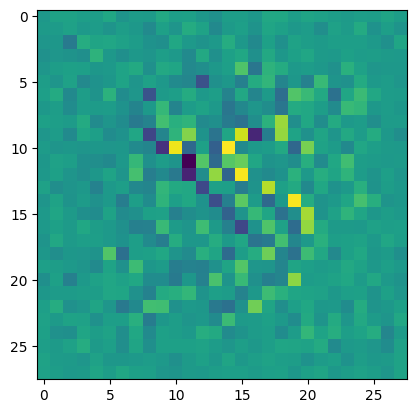

 68%|██████▊   | 34/50 [07:07<03:28, 13.05s/it]

tensor(9.4785) tensor(-10.6836) 7.135871 -6.417743


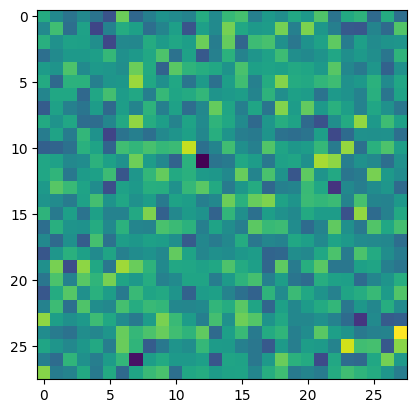

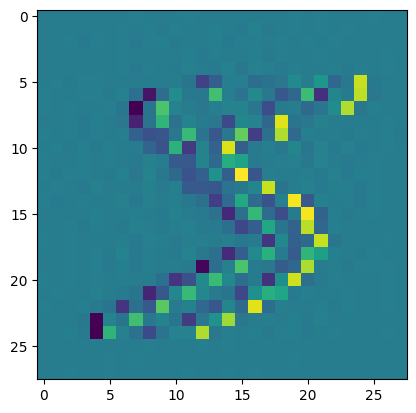

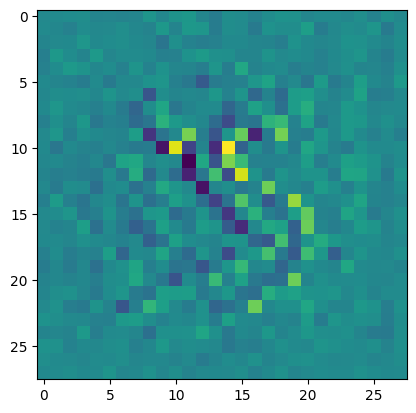

 70%|███████   | 35/50 [07:20<03:13, 12.88s/it]

tensor(9.5637) tensor(-9.0790) 8.659069 -6.417743


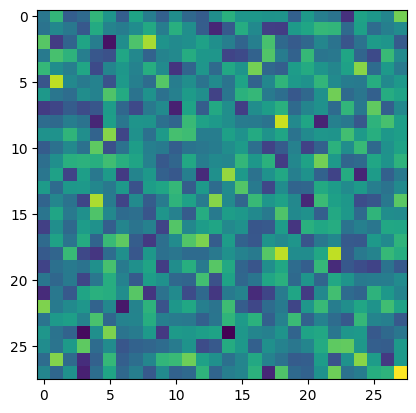

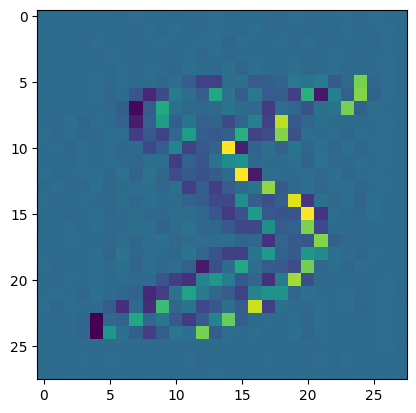

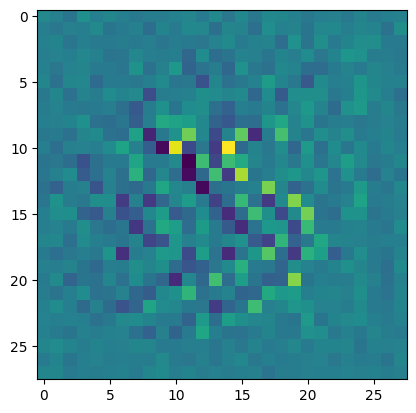

 72%|███████▏  | 36/50 [07:33<02:58, 12.78s/it]

tensor(9.3736) tensor(-8.4691) 7.9742975 -6.417743


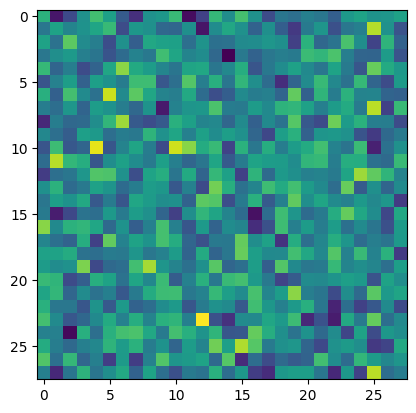

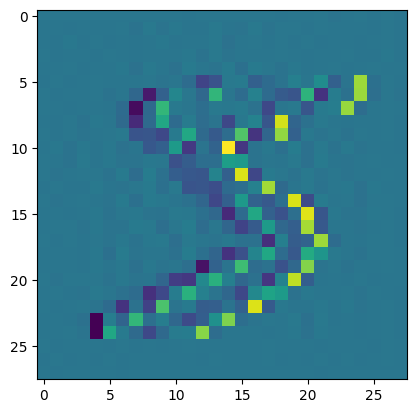

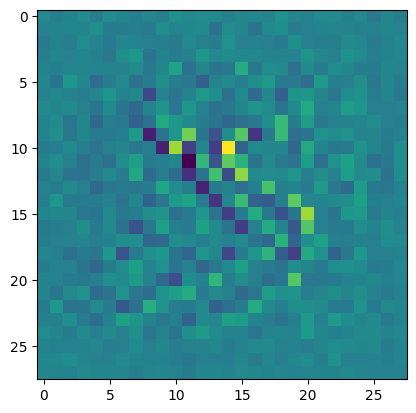

 74%|███████▍  | 37/50 [07:45<02:45, 12.70s/it]

tensor(8.5857) tensor(-8.5047) 8.265899 -6.417743


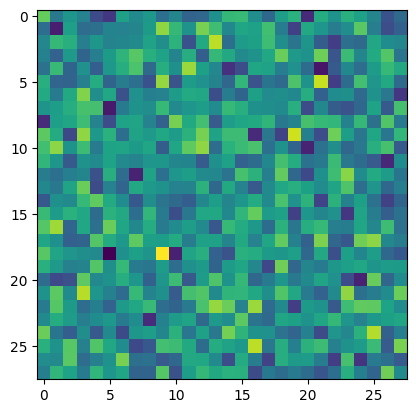

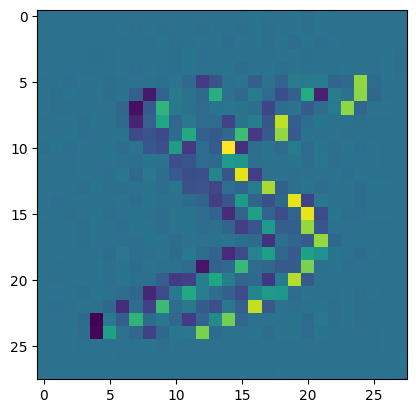

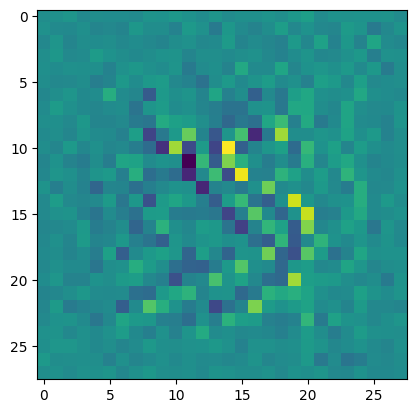

 76%|███████▌  | 38/50 [07:58<02:32, 12.68s/it]

tensor(8.5493) tensor(-9.6053) 89.35478 -59.60326


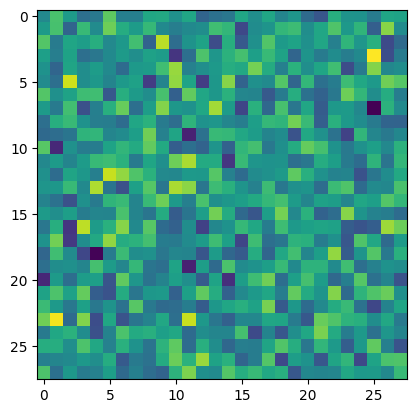

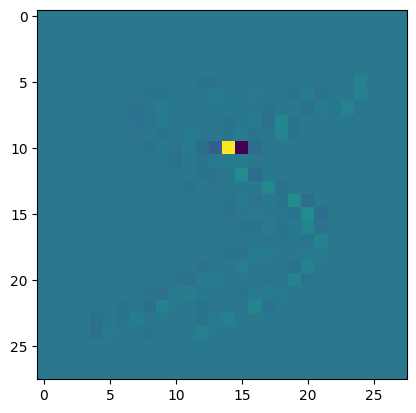

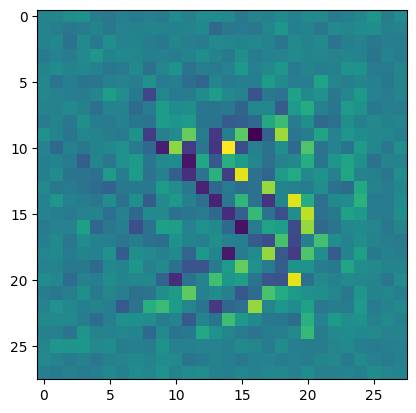

 78%|███████▊  | 39/50 [08:10<02:19, 12.64s/it]

tensor(10.8804) tensor(-10.0449) 7.8305683 -6.417743


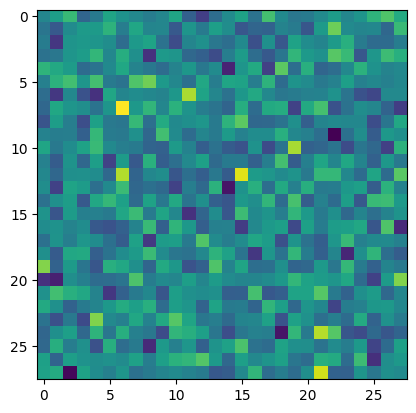

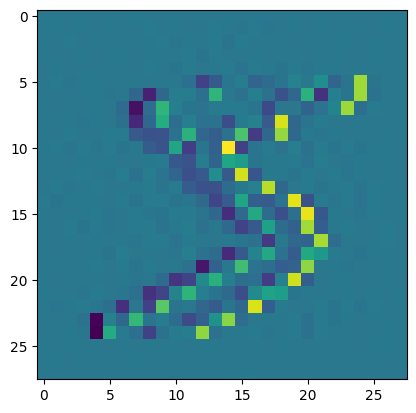

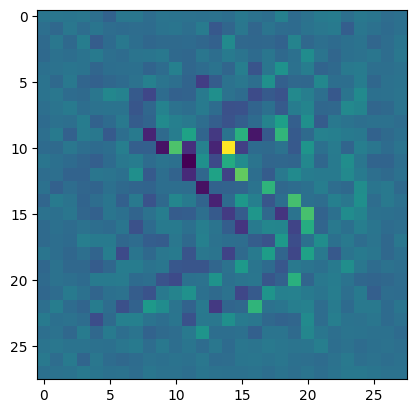

 80%|████████  | 40/50 [08:23<02:05, 12.60s/it]

tensor(11.6429) tensor(-8.1894) 9.461902 -6.417743


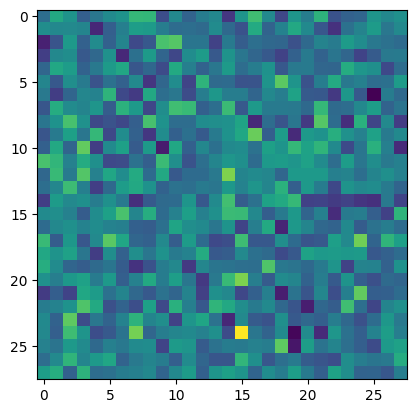

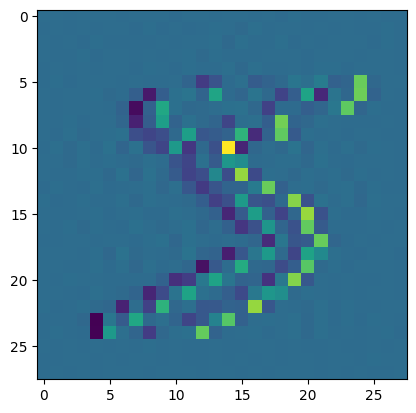

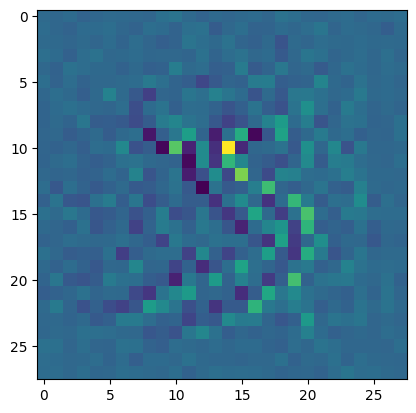

 82%|████████▏ | 41/50 [08:35<01:52, 12.54s/it]

tensor(9.5550) tensor(-9.5615) 64.46811 -91.9947


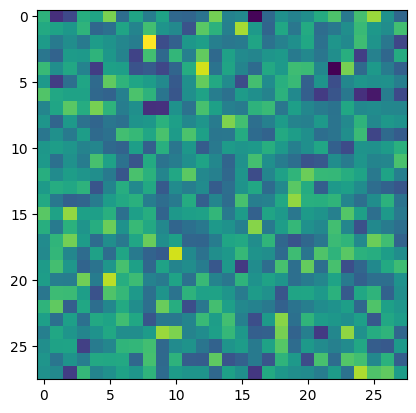

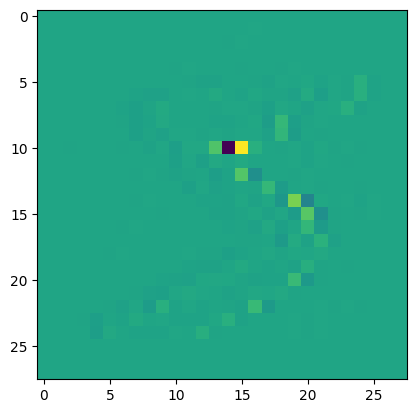

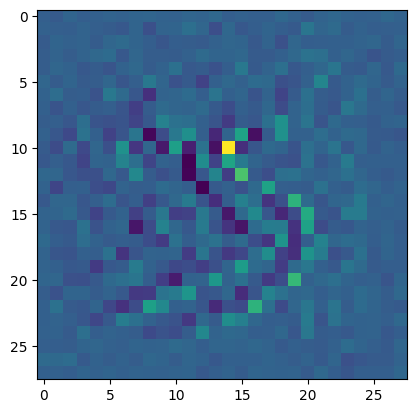

 84%|████████▍ | 42/50 [08:48<01:41, 12.63s/it]

tensor(8.5745) tensor(-9.1923) 19.53626 -11.283077


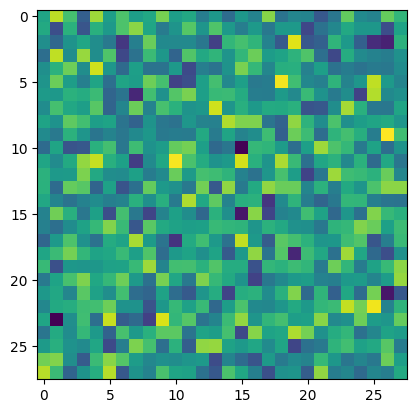

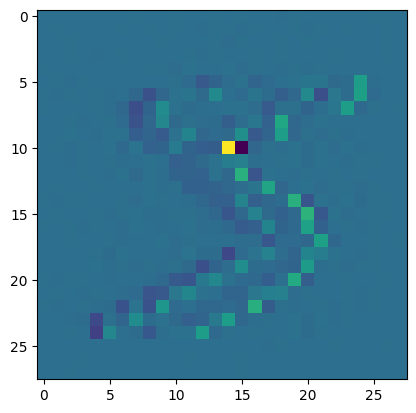

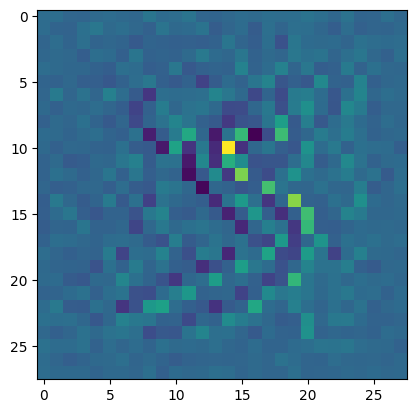

 86%|████████▌ | 43/50 [09:01<01:28, 12.66s/it]

tensor(8.7865) tensor(-7.6008) 10.400814 -6.417743


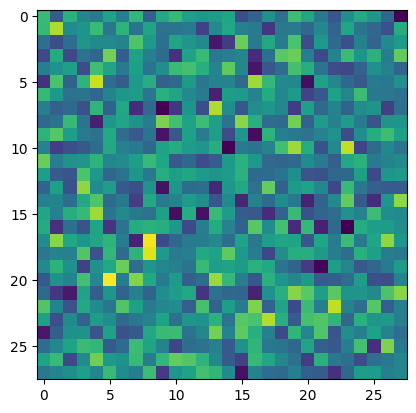

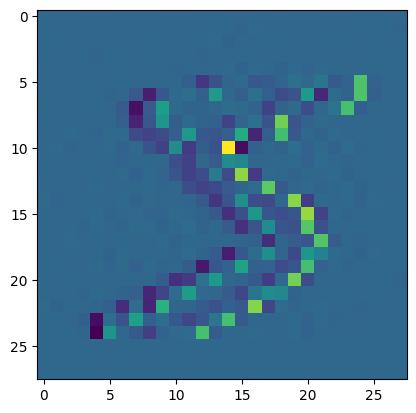

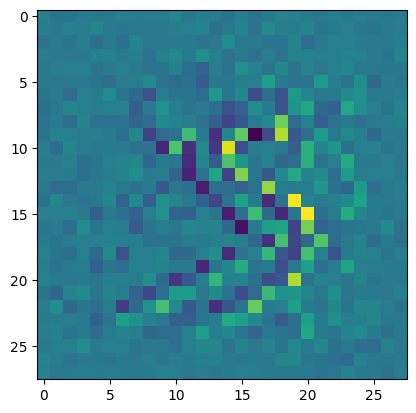

 88%|████████▊ | 44/50 [09:14<01:16, 12.76s/it]

tensor(9.2262) tensor(-9.3123) 38.829155 -25.187323


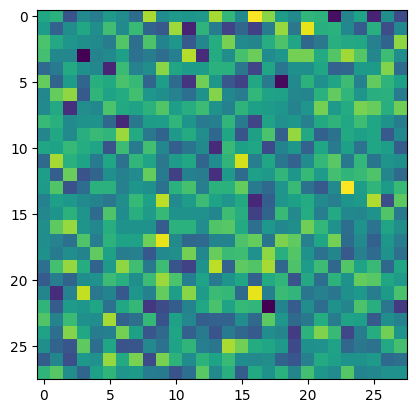

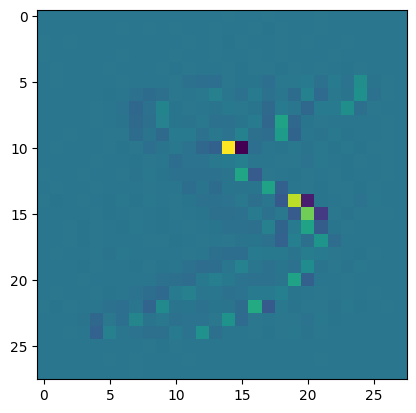

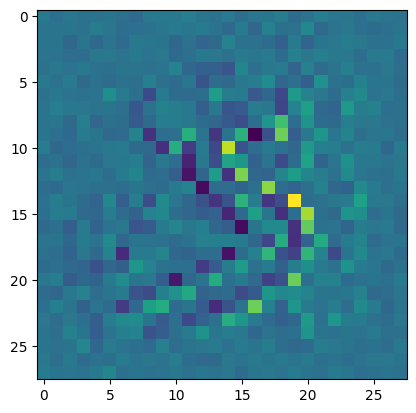

 90%|█████████ | 45/50 [09:26<01:03, 12.66s/it]

tensor(9.6958) tensor(-8.8658) 7.9265575 -6.417743


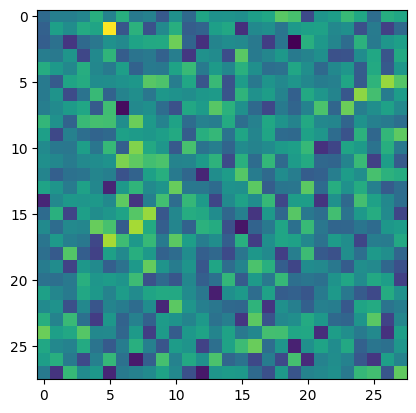

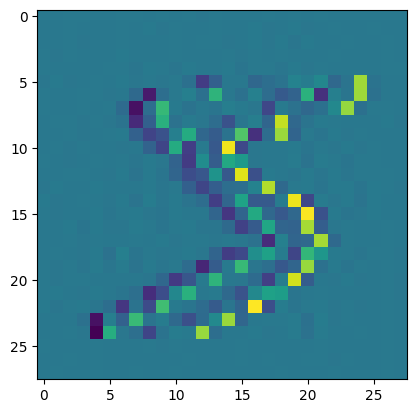

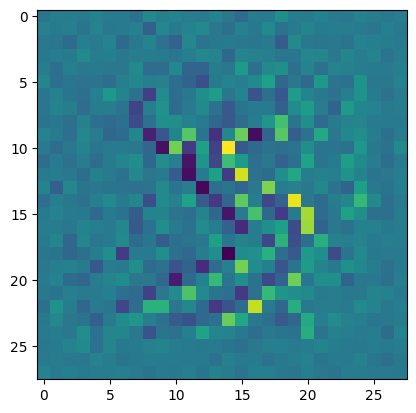

 92%|█████████▏| 46/50 [09:39<00:50, 12.62s/it]

tensor(10.1388) tensor(-9.6469) 11.190279 -6.417743


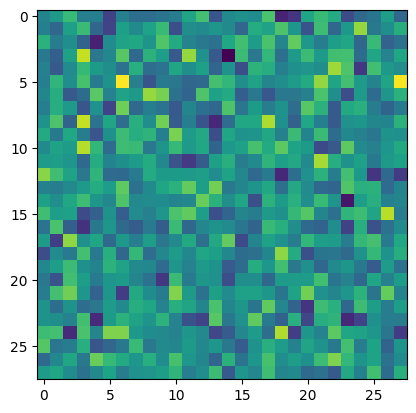

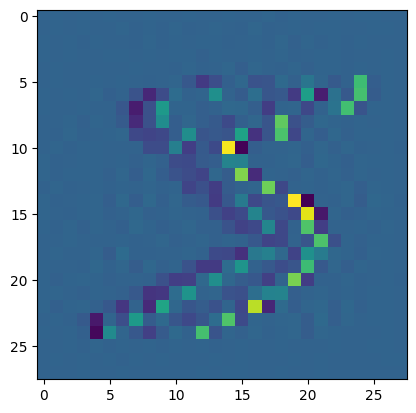

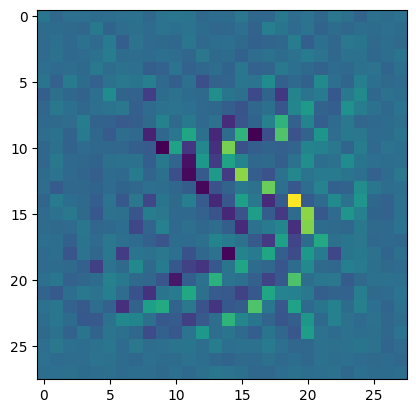

 94%|█████████▍| 47/50 [09:51<00:37, 12.60s/it]

tensor(8.9858) tensor(-9.8000) 10.840952 -6.417743


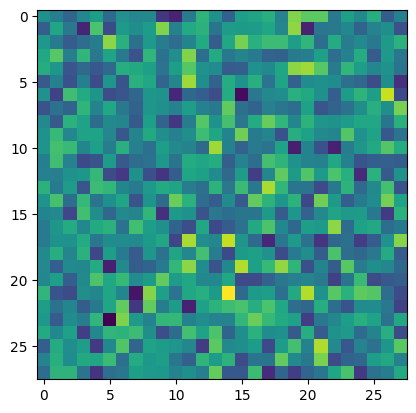

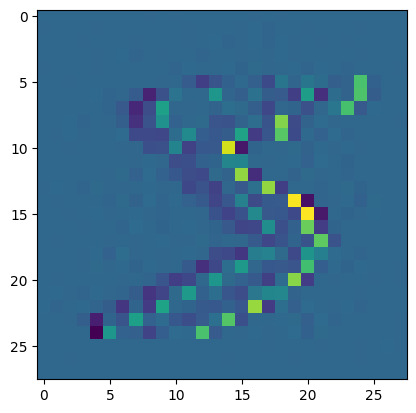

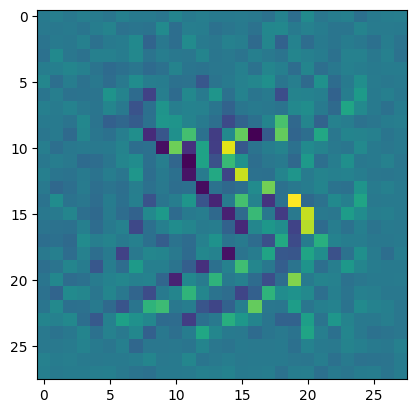

 96%|█████████▌| 48/50 [10:04<00:25, 12.61s/it]

tensor(8.8532) tensor(-8.7992) 13.239485 -6.897581


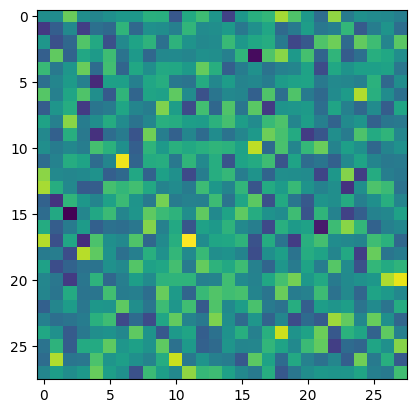

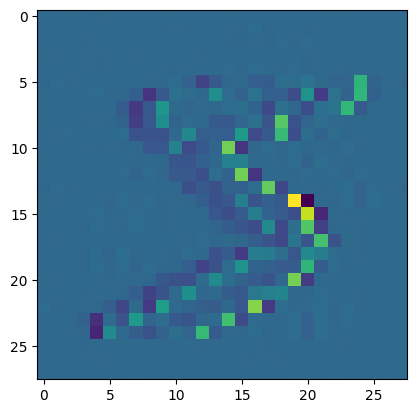

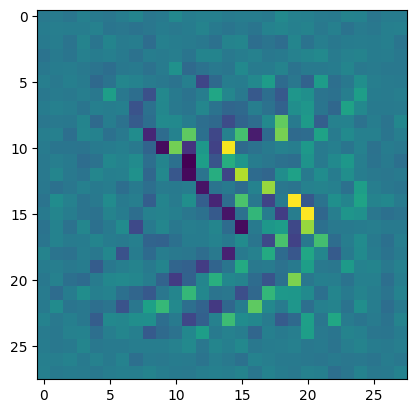

 98%|█████████▊| 49/50 [10:17<00:12, 12.63s/it]

tensor(9.7855) tensor(-8.8417) 9.351982 -6.417743


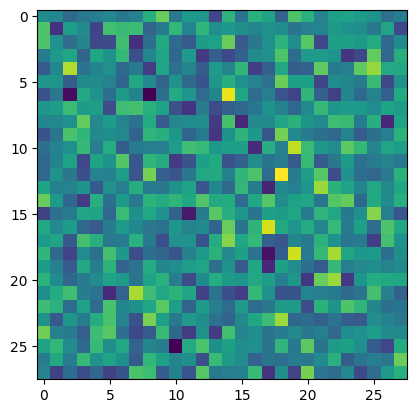

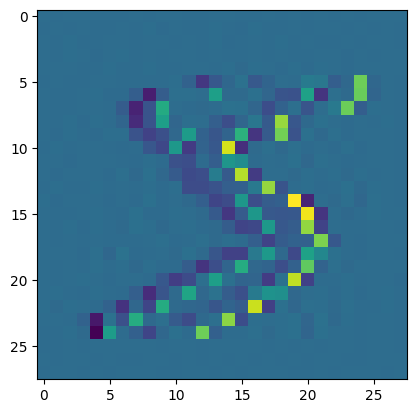

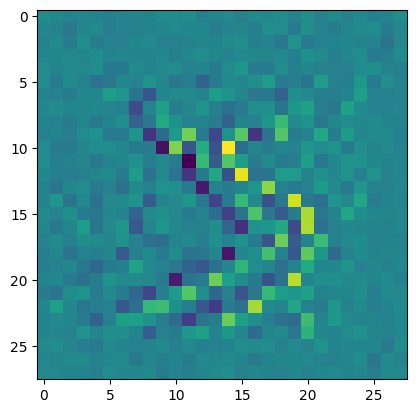

100%|██████████| 50/50 [10:29<00:00, 12.59s/it]


model has been saved


In [216]:
model_score = ScoreNet()
loss_fn = torch.nn.MSELoss()
optimizer = SGD(model_score.parameters(), lr=1e-2, momentum=0.9)
mm_scaler = MinMaxScaler()
model_score.train()

for e in tqdm(range(epoch)):
  # we want to sample from random time steps to construct training samples
  random_t = np.random.rand(N-3)
  random_t = np.insert(random_t, 0, dt) # first step we want something small
  random_t = np.insert(random_t, 0, 1)
  random_t = np.sort(random_t) # we sort the time in increasing order for denoising
  time_ = np.insert(random_t, 0, eps).astype(np.float32) # for denoising we want time 0 to always be in sample to train
  sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().numpy()

  # for x,_ in data_loader:
  data = mnist.data[0]
  x[0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
  kde = KernelDensity(kernel='gaussian').fit(data.ravel()[:, None])
  m[0] = kde.score_samples(data.ravel()[:, None])
  del_m[0] = np.diff(m[0].ravel(), axis=0, prepend=m[0,0]) #/ (2*sigma_[0]**2)

  # we normalize for sigma to ensure the dynamics doesn't blow up
  A_block = []
  for i, t_ in enumerate(random_t, 1):
    A = construct_A(dx, dy, t_ - time_[i-1], np.zeros((H, W)), sigma_[i], scores[i], H, W)
    if i == 1:
      A_block = sp.linalg.block_diag(A)
    else:
      A_block = sp.linalg.block_diag(A_block, A)
      A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])

  B = construct_B(dx, dy, time_[1] - time_[0], m[0], np.zeros((H, W)), sigma_[1], scores[1])
  B_block = np.zeros(A_block.shape[0])
  B_block[:H*W] = B
  m[1:] = solve_pde(A_block, B_block).reshape((N-1, H*W))

  # constructing the training data and labels
  for i, t_ in enumerate(random_t, 1):
    del_m[i] = np.diff(m[i].ravel(), axis=0, prepend=m[i, 0]) #/ (2*sigma_[i]**2)

  x = torch.tensor(mm_scaler.fit_transform(np.exp(-m).ravel()[:, None])).reshape((N, 1, H, W))
  perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
  print(perturbed_x.max(), perturbed_x.min(), del_m.max(), del_m.min())
  train_x_data = perturbed_x
  train_y_data = torch.tensor(del_m.astype(np.float32)).reshape((N, 1, H, W))

  plt.imshow(train_x_data[-1].detach().numpy().reshape((H, W)))
  plt.show()

  plt.imshow(train_y_data[-1].reshape((H, W)))
  plt.show()

  y_pred = model_score(train_x_data, torch.tensor(time_))
  lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]
  loss = loss_fn(y_pred / lm, train_y_data)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses = loss.item()

  scores = (y_pred / lm).clone().detach().numpy().reshape((N, H, W)) # we normalize before fedding back into PDE

  plt.imshow(scores[0].reshape((H, W))) # so we can see that the score should look something like this after training
  plt.show()

torch.save(model_score.state_dict(), 'ckpt.pth')
print(f"\nmodel has been saved")

# Solving the ODE

In [212]:
#@title ODE functions

from scipy import integrate

## The error tolerance for the black-box ODE solver
def ode_sampler(score_model,
                diffusion_coeff,
                batch_size=64,
                z=None,
                eps=eps):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, H, W) # * torch.sqrt(2 * diffusion_coeff(torch.ones(batch_size, 1, H, W), sigma)**2)
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, dtype=torch.float32).reshape(shape)

    time_steps = torch.tensor(time_steps, dtype=torch.float32).reshape((sample.shape[0],))
    with torch.no_grad():
      score_ = score_model(sample, time_steps)
  # plt.imshow(score_.reshape((H, W)))
  # plt.show()
    return score_.cpu().numpy().reshape((-1))

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    # time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t), sigma)
    return  -0.5 * (g**2) * score_eval_wrapper(x, t)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1))
  print(f"Number of function evaluations: {res.nfev}")
  sol = res.y[:, -1].reshape(shape)
  return sol

## Sample ODE

Number of function evaluations: 296


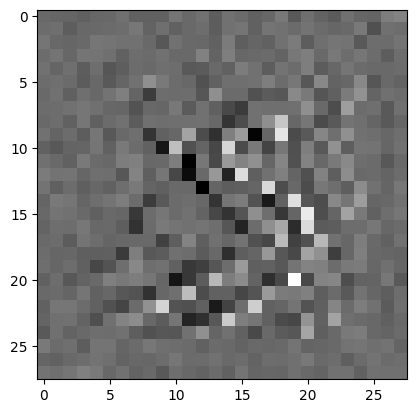

In [219]:
from scipy import integrate

ckpt = torch.load('ckpt.pth')
model_score.load_state_dict(ckpt)
model_score.eval()

sample_batch_size = 1 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

# init_x = perturbed_x[-1].reshape((sample_batch_size, 1, H, W))

## Generate samples using the specified sampler.
samples = sampler(model_score,
                  diffusion_coeff,
                  sample_batch_size)

plt.imshow(samples.reshape(H, W), cmap = 'gray')
plt.show()

# Tutorial on Diffusion Models

tutorial on diffusion model can be found on https://colab.research.google.com/drive/1d2-L9uPKQNqZcgpK7CZzhHrCmwQsz5BC?usp=sharing


